[Reference](https://medium.com/analytics-vidhya/a-must-read-nlp-tutorial-on-neural-machine-translation-the-technique-powering-google-translate-c5c8d97d7587)

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/Medium')
!pwd

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Medium


The dataset can be found [here](www.manythings.org/anki/)

In [3]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [4]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [5]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [6]:
data = read_text("deu.txt")
print(data)
deu_eng = to_lines(data) 
print(deu_eng)
deu_eng = array(deu_eng)
print(deu_eng)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['Go.' 'Geh.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)']
 ['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ...
 ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker."
  'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #3807493 (Tickler)']
 ["If someone who doesn't know your background says that you

In [8]:
# To run fast, I will use only first 50,000 sentences.
deu_eng = deu_eng[:50000,:]

In [9]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['No one encouraged her.', 'Niemand ermutigte sie.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #40334 (Swift) & #370461 (Wolf)'],
       ['No one has that right.', 'Niemand hat dieses Recht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176735 (sprachensprech)'],
       ['No one has that right.', 'Dieses Recht hat niemand.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176738 (sprachensprech)']],
      dtype='<U537')

# Text preprocessing

In [10]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

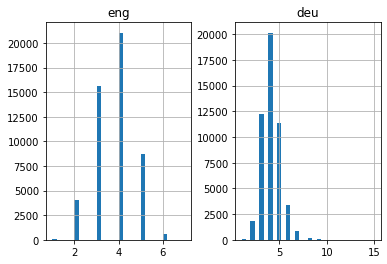

In [12]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l}) 
length_df.hist(bins = 30) 
plt.show()

In [13]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 

print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


In [14]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# Building the model

In [15]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

German will be the input and English should be the target.

In [16]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) 

# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [17]:
# build NMT model 
def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [18]:
# model compilation (with 512 hidden units)
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'model.h1.24_jan_19' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4087
Epoch 00001: val_loss improved from inf to 2.83547, saving model to model.h1.24_jan_19
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 342s 5s/step - loss: 3.4087 - val_loss: 2.8355
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7718
Epoch 00002: val_loss improved from 2.83547 to 2.78998, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 340s 5s/step - loss: 2.7718 - val_loss: 2.7900
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6031
Epoch 00003: val_loss improved from 2.78998 to 2.54184, saving mo

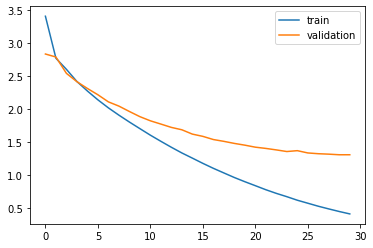

In [21]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

In [22]:
model = load_model('model.h1.24_jan_19') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [23]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

In [24]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], eng_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],eng_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [25]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : 
                        preds_text})

In [26]:
# print 15 rows randomly 
pred_df.sample(15)

,actual,predicted
9154,i hope you win,i hope you win
2744,you missed a lot,you missed a lot
1100,they said its ok,they said that fine
8591,he asked after you,he asked after you
4010,i plan to be there,i worked to be
4417,i made this chair,i took the
3920,im very nervous,im very nervous
9660,i know tom helped you,i know tom likes you
5165,whats your price,what your good
3098,i heard the good news,i have the good
